## Welcome to the Community

An introduction to community detection and community similarity in python.

by Alexander J. Gates

In [1]:
import os
import itertools
import numpy as np
import networkx as nx
import scipy.io as sio
import community  # pip install python-louvain


# pip install clusim
from clusim.clustering import Clustering, print_clustering
import clusim.sim as sim
import clusim.clugen as clugen

import matplotlib.pylab as plt
%matplotlib inline


# some funcitons to help us draw the networks


def blank_axis(ax):

    # Get rid of ticks. The position of the numbers is informative enough of
    # the position of the value.
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set(aspect = 1)

    for xlabel in ax.axes.get_xticklabels():
        xlabel.set_visible(False)

    for ylabel in ax.axes.get_yticklabels():
        ylabel.set_visible(False)

    return ax

def draw_network_partition(graph, clustering, pos = None, node_size = 80, node_alpha = 1.0,
                           edge_color = '0.8', node_cmap = 'Set2', ax = None):
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(8,8))
    ax = blank_axis(ax)
    
    if pos is None:
        pos = nx.spring_layout(graph)

    for cluster, cluster_nodes in clustering.clu2elm_dict.items():

        nx.draw_networkx_nodes(graph, pos, cluster_nodes, node_size = node_size, alpha=node_alpha, 
                               cmap = node_cmap, vmax = clustering.n_clusters, vmin=0.,
                                    node_color = [float(cluster)]*len(cluster_nodes), ax=ax)

    if not edge_color is None:
        nx.draw_networkx_edges(graph, pos, alpha=1.0, edge_color = edge_color, ax=ax)
    
    return ax


def largest_connected_component(graph, directedcc = 'weak'):
    lcc = graph
    
    if not graph.is_directed():
        for lcc in nx.connected_components(graph):
            break
    else:
        if directedcc == 'weak':
            for lcc in nx.weakly_connected_components(graph):
                break
        elif directedcc == 'strong':
            for lcc in nx.strongly_connected_components(graph):
                break
                
    return lcc

# Load the Zachary Karate Club Network
This network is so common in the field that there is a special function in NetworkX just to generate the Karate Club graph

In [2]:
# load the karate club graph

kc_graph = nx.karate_club_graph()
print(nx.info(kc_graph))

pos = nx.spring_layout(kc_graph)

kc_community_names = {'Mr. Hi':0, 'Officer':1}
kc_ground_truth_community = Clustering({n:[kc_community_names[d['club']]] for n, d in kc_graph.nodes(data=True)})
print(kc_ground_truth_community.clu_size_seq)

Name: Zachary's Karate Club
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882
[17, 17]


Lets plot the network and color the nodes based on the two post-schism factions (the ground-truth communities for this network).

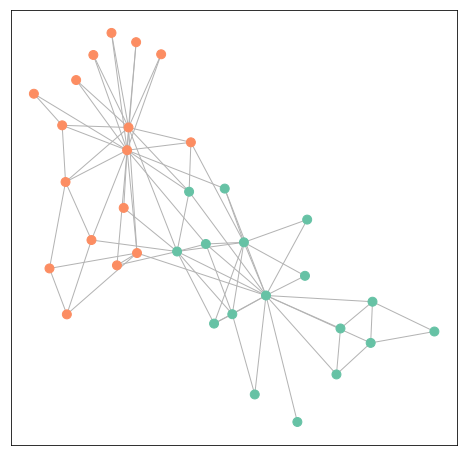

In [3]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

for cluster, cluster_nodes in kc_ground_truth_community.clu2elm_dict.items():
    
    nx.draw_networkx_nodes(kc_graph, pos, cluster_nodes, node_size = 80, cmap = 'Set2', vmax = 3., vmin=0.,
                                node_color = [float(cluster) / kc_ground_truth_community.n_clusters]*len(cluster_nodes), ax=ax)


nx.draw_networkx_edges(kc_graph, pos, alpha=1.0, edge_color = '0.7', ax=ax)
plt.show()

Now we can use the python-louvain package to detect the optimal community structure in the network.
Details on the package can be found here: https://python-louvain.readthedocs.io/en/latest/

In [4]:
louvain_raw = community.best_partition(kc_graph, random_state = 0)
louvain_modularity = community.modularity(louvain_raw, kc_graph)
louvain_clustering = Clustering().from_membership_list([louvain_raw[inode] for inode in range(len(kc_graph))])
print("The best partition has modularity %f with %d communities of sizes %s" % (louvain_modularity, louvain_clustering.n_clusters, louvain_clustering.clu_size_seq))

The best partition has modularity 0.415598 with 4 communities of sizes [12, 5, 13, 4]


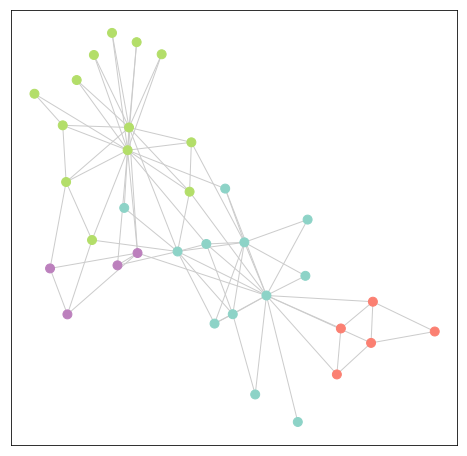

In [5]:
#drawing
fig, ax = plt.subplots(1,1,figsize=(8,8))

for cluster, cluster_nodes in louvain_clustering.clu2elm_dict.items():
    
    nx.draw_networkx_nodes(kc_graph, pos, cluster_nodes, node_size = 80, cmap = 'Set3', vmax = 1., vmin=0.,
                                node_color = [float(cluster) / louvain_clustering.n_clusters]*len(cluster_nodes), ax=ax)


nx.draw_networkx_edges(kc_graph, pos, alpha=1.0, edge_color = '0.8', ax=ax)
plt.show()

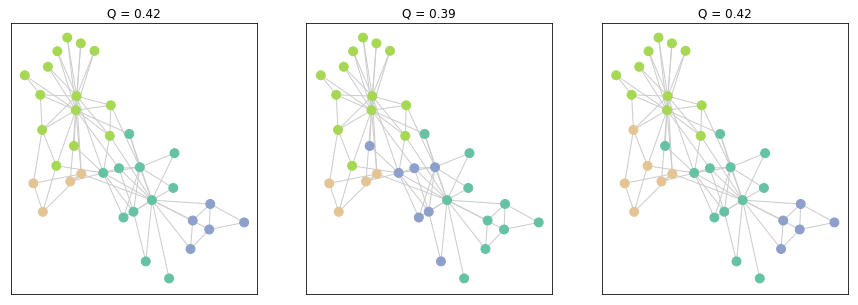

In [6]:


fig, ax = plt.subplots(1,3, figsize=(15,5))

for iax in range(3):
    randpartition = community.best_partition(kc_graph, random_state = iax+11)
    randclustering = Clustering().from_membership_list([randpartition[inode] for inode in range(len(kc_graph))])

    draw_network_partition(kc_graph, randclustering, pos = pos, ax = ax[iax])
    partition_modularity = community.modularity(randpartition, kc_graph)
    ax[iax].set_title('Q = %0.2f' % partition_modularity)
plt.savefig('')
plt.show()

# A little bit about the CluSim objects

the CluSim package is built around the Clustering object
> myclustering = Clustering()

You can create a Clustering() many ways:

from a membership_list [0,0,0,1,1]
> Clustering().from_membership_list

from an igraph covering
> Clustering().clustering_from_igraph_cover

from an element membership dict {element:[comm1, comm2]}
> Clustering(elm2clu_dict)

or from a cluster 2 elment dict {comm1:[elm1, elm2, elm3]}
> Clustering(clu2elm_dict)

# Random Clusterings

There are many supporting functions that allow you to generate a 'random clustering / community' in the clugen subpackage.
> clugen.make_random_clustering(n_elements=3, n_clusters=2, clu_size_seq=[1, 2], random_model='all')


We can also generate a Clustering as a manipulation of another Clustering:
> clugen.shuffle_memberships(myclustering, percent = 0.25)



# Calculating Similarity Between Clusterings
The clusim.sim subpackage contains over 25 clustering similarity measures (constantly being updated)

All measures work by plugging in two clusterings.  When directionality matters, the second clustering is treated as the 'Ground Truth'.
> sim.nmi(clustering1, clustering2)

We also have access to the analytically adjusted Rand Index and Mutual Information
> sim.adj_mi(clustering1, clustering2, random_model='all')  # 'perm' or 'num'

As well as the element-centric similarity measure between two clusterings
> sim.element_sim(clustering1, clustering2, alpha = 0.9)

Or the element-centric similarity measure score for each element / node
> sim.element_sim_elscore(clustering1, clustering2, alpha = 0.9)

# Element-centric Frustration reveals lack of coherent community structure

In this example, we will consider the modularity of a random graph and see how we can learn about the "LACK" of any community structure.

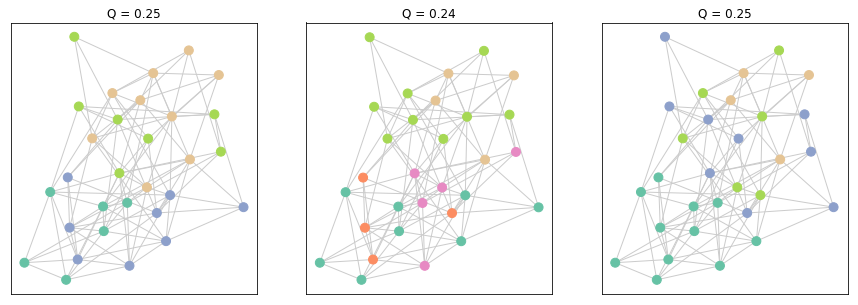

In [7]:
# create a random ER graph
random_graph = nx.erdos_renyi_graph(30, 0.25)
pos = nx.spring_layout(random_graph)

fig, ax = plt.subplots(1,3, figsize=(15,5))

for iax in range(3):
    # now we draw three examples of the 'best partition' of the graph
    randpartition = community.best_partition(random_graph, random_state = iax)
    randclustering = Clustering().from_membership_list([randpartition[inode] for inode in range(len(random_graph))])
    
    randQ = community.modularity(randpartition, random_graph)
    draw_network_partition(random_graph, randclustering, pos = pos, ax = ax[iax])
    ax[iax].set_title('Q = %0.2f' % randQ)
plt.show()

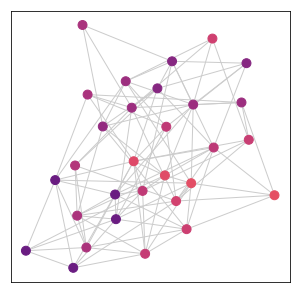

In [8]:

fig, ax = plt.subplots(1,1, figsize=(5,5))

# now we sample 10 communities on this network
best_communities = []
for iax in range(10):
    randpartition = community.best_partition(random_graph, random_state = iax)
    best_communities.append(Clustering().from_membership_list([randpartition[inode] for inode in range(len(random_graph))]))
    
# can calculate the average element-wise similarity between all pairs of communities we detected in the previous stage
node_sim = np.zeros(30)
for icomm, jcomm in itertools.combinations(best_communities, 2):
    ec, relabel = sim.element_sim_elscore(icomm, jcomm)  # note element_sim returns a relabel dict in case your nodes are not integers
    node_sim += ec
node_sim = node_sim/(45)   

nx.draw_networkx_nodes(random_graph, pos, node_size = 80, alpha=1.0, 
                               cmap = 'magma_r', vmax = 1, vmin=0.,
                                    node_color = node_sim, ax=ax)
nx.draw_networkx_edges(random_graph, pos, alpha=1.0, edge_color = '0.8', ax=ax)


plt.show()